In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
path1 = '/kaggle/input/fer-data/FER-data-original/'
path2 = '/kaggle/input/fer-data/FER-data/'

In [4]:
x_train_load = np.load(path1 + 'fer-trainx-complete.npy')
y_train_load = np.load(path1 + 'fer-trainy-complete.npy')
x_test_normalized = np.load(path2 + 'fer-testx-complete.npy')
y_test = np.load(path2 + 'fer-testy-complete.npy')

In [5]:
# dividing data into training and validation set

from sklearn.model_selection import train_test_split

x_train_normalized, x_val, y_train, y_val = train_test_split(x_train_load, y_train_load, test_size=0.3, random_state=5)

print(f'x_train.shape = {x_train_normalized.shape}        y_train.shape{y_train.shape}')
print(f'x_val.shape = {x_val.shape}        y_val.shape{y_val.shape}')

x_train.shape = (20095, 48, 48)        y_train.shape(20095,)
x_val.shape = (8613, 48, 48)        y_val.shape(8613,)


In [6]:
def train_model(model,datagen,learning_rate,epochs,batch_size,callbacks=None):
    my_model = model(learning_rate)
    
    train_generator = datagen.flow(x_train_normalized.reshape(-1,48,48,1), y_train, batch_size=32)
    
    history = my_model.fit(train_generator, epochs=epochs,
                        batch_size=batch_size, validation_data=(x_val,y_val),
                        shuffle = True, callbacks=callbacks)

    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return my_model, epochs, hist

def show_graphs(epochs, hist):
    plt.figure(figsize=(5.5,5.5))
    plt.plot(epochs, hist['accuracy'], label = 'accuracy')
    plt.plot(epochs, hist['val_accuracy'], label = 'val_accuracy')
    plt.yticks(np.linspace(0, 1, 11))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def test_model(my_model):
    loss, acc = my_model.evaluate(x_test_normalized, y_test)
    print('Test Accuracy = %.3f %%' %(acc*100))

def conf_matrix(model):
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    predictions = model.predict(x_test_normalized)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = y_test

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(7)+0.5, labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])
    plt.yticks(np.arange(7)+0.5, labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])
    plt.title('Conf Matrix (Absolute)')

    plt.subplot(122)
    cm = cm.astype(float)
    for i in range(len(cm)):
        cm[i] = 100*cm[i]/np.sum(cm[i])
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(7)+0.5, labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])
    plt.yticks(np.arange(7)+0.5, labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])
    plt.title('Conf Matrix (Percentage)')

    plt.show()


def generate_report(model):
    predictions = model.predict(x_test_normalized)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = y_test

    print(classification_report(true_labels, predicted_labels))

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=25,      
    width_shift_range=0.15,  
    height_shift_range=0.15,
    shear_range=0.1,        
    zoom_range=0.1,         
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
def create_cnn_model(my_learning_rate):
    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape = (48,48,1)))
    model.add(keras.layers.Conv2D(64,3,activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64,3, activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(2))

    model.add(keras.layers.Conv2D(128,3,activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(256,3,activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(256,3, activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(2))

    model.add(keras.layers.Conv2D(1024,3,activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(2))
    
    model.add(keras.layers.Conv2D(512,3,activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(750, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Dense(7, activation='softmax'))

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = my_learning_rate),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [9]:
model = create_cnn_model(0.001)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 1024)   │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 750)            │    13,824,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 750)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         5,257 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 21,915,319 (83.60 MB)

 Trainable params: 21,910,711 (83.58 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
    patience=12,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the weights of the best epoch
    mode='max'             # Mode: 'min' for loss, 'max' for accuracy
)

In [11]:
model_cnn, epochs, hist = train_model(create_cnn_model, datagen, learning_rate=0.0006,
                                      epochs=120, batch_size=32,
                                      callbacks=[early_stopping])

Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725287684.655506     102 service.cc:145] XLA service 0x7b8f5c0090d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725287684.655566     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/628 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.1561 - loss: 6.8012

I0000 00:00:1725287692.851790     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.2333 - loss: 2.2641 - val_accuracy: 0.3189 - val_loss: 1.7550
Epoch 2/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.3048 - loss: 1.7179 - val_accuracy: 0.3540 - val_loss: 1.6081
Epoch 3/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.3748 - loss: 1.5674 - val_accuracy: 0.3099 - val_loss: 1.9092
Epoch 4/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.3999 - loss: 1.5158 - val_accuracy: 0.4759 - val_loss: 1.3426
Epoch 5/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.4381 - loss: 1.4337 - val_accuracy: 0.5063 - val_loss: 1.3344
Epoch 6/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.4572 - loss: 1.3942 - val_accuracy: 0.5086 - val_loss: 1.3236
Epoch 7/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.4850 - loss: 1.3435 - val_accuracy: 0.4915 - val_loss: 1.3804
Epoch 8/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5116 - loss: 1.2974 - val_

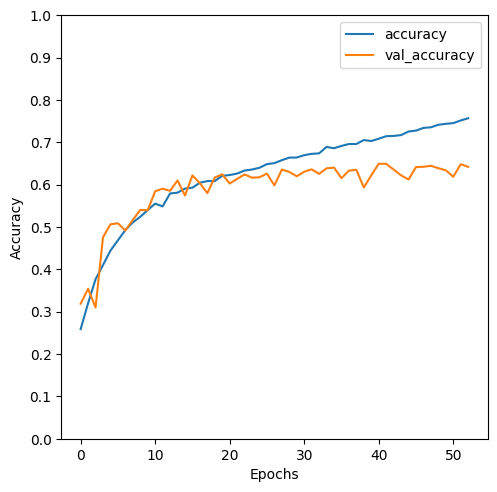

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5926 - loss: 1.2010
Test Accuracy = 64.043 %
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


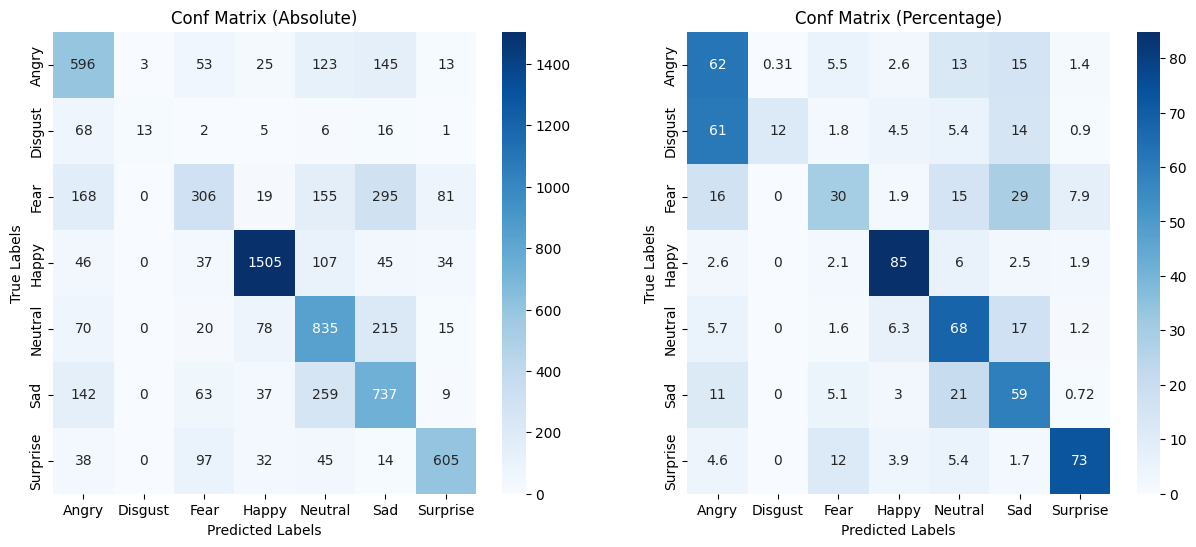

In [12]:
show_graphs(epochs, hist)
test_model(model_cnn)
conf_matrix(model_cnn)

In [13]:
generate_report(model_cnn)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       958
           1       0.81      0.12      0.20       111
           2       0.53      0.30      0.38      1024
           3       0.88      0.85      0.87      1774
           4       0.55      0.68      0.60      1233
           5       0.50      0.59      0.54      1247
           6       0.80      0.73      0.76       831

    accuracy                           0.64      7178
   macro avg       0.66      0.55      0.56      7178
weighted avg       0.65      0.64      0.63      7178



In [14]:
def create_vgg_model(learning_rate):
    base_model = keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(48,48,3)
    )
    
    inputs = keras.layers.Input(shape=(48,48,1))
    x = keras.layers.Conv2D(3, 3, padding='same', activation='relu')(inputs)
    x = base_model(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(7, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [15]:
model = create_vgg_model(0.001)
model.summary() 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 48, 48, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,110,501 (57.64 MB)

 Trainable params: 15,110,501 (57.64 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=10, 
                              min_lr=1e-6)

In [17]:
model_vgg, epochs, hist = train_model(create_vgg_model, datagen, learning_rate=0.0001, epochs=70, 
                                     batch_size=32, callbacks=[reduce_lr])


Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/628 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.1615 - loss: 1.9943

I0000 00:00:1725288653.931439     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads



304/628 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.2210 - loss: 1.8620

I0000 00:00:1725288666.469376     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads



628/628 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.2276 - loss: 1.8439 - val_accuracy: 0.3476 - val_loss: 1.6991 - learning_rate: 1.0000e-04
Epoch 2/70
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.3677 - loss: 1.5731 - val_accuracy: 0.4627 - val_loss: 1.3984 - learning_rate: 1.0000e-04
Epoch 3/70
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.4593 - loss: 1.3900 - val_accuracy: 0.4814 - val_loss: 1.3288 - learning_rate: 1.0000e-04
Epoch 4/70
628/628 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5104 - loss: 1.2896 - val_accuracy: 0.5563 - val_loss: 1.1782 - learning_rate: 1.0000e-04
Epoch 5/70
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5357 - loss: 1.2347 - val_accuracy: 0.5569 - val_loss: 1.1559 - learning_rate: 1.0000e-04
Epoch 6/70
628/628 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5620 - loss: 1.1751 - val_accuracy: 0.5768 - val_loss: 1.1060 - learning_rate: 1.0000e-04
Epoch 7/70
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accurac

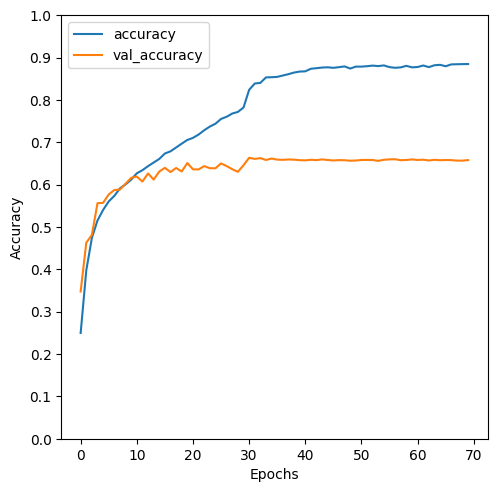

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6331 - loss: 1.4464
Test Accuracy = 65.743 %
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


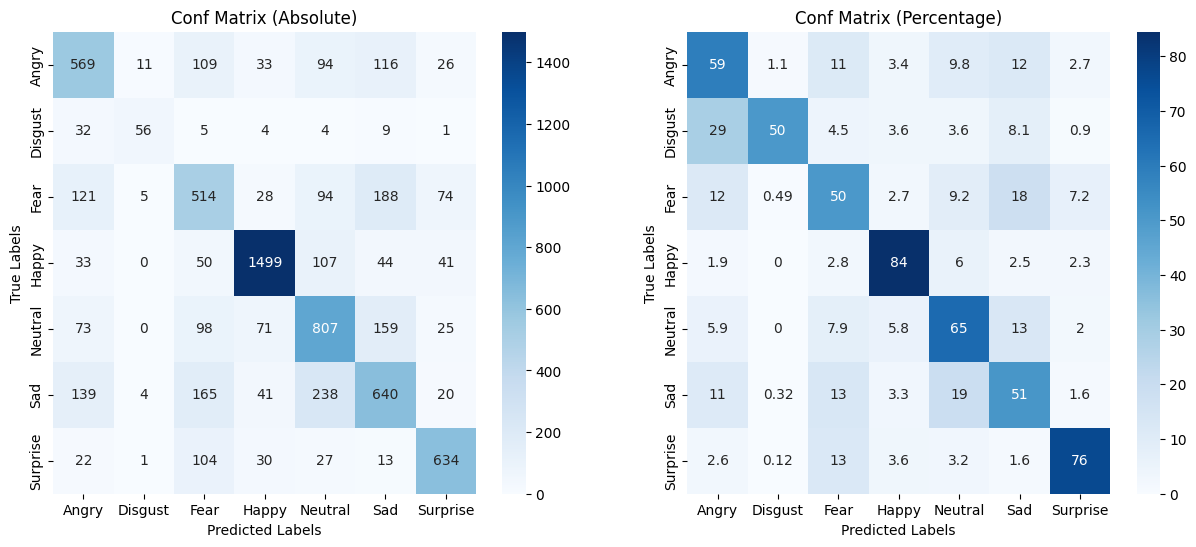

In [18]:
show_graphs(epochs, hist)
test_model(model_vgg)
conf_matrix(model_vgg)

In [19]:
generate_report(model_vgg)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.58      0.59      0.58       958
           1       0.73      0.50      0.60       111
           2       0.49      0.50      0.50      1024
           3       0.88      0.84      0.86      1774
           4       0.59      0.65      0.62      1233
           5       0.55      0.51      0.53      1247
           6       0.77      0.76      0.77       831

    accuracy                           0.66      7178
   macro avg       0.65      0.63      0.64      7178
weighted avg       0.66      0.66      0.66      7178



In [20]:
def create_resnet_model(learning_rate):
    base_model = keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=(48,48,3)
    )
    
    inputs = keras.layers.Input(shape=(48,48,1))
    x = keras.layers.Conv2D(3, 3, padding='same', activation='relu')(inputs)
    x = base_model(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(7, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
model = create_resnet_model(0.001)
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,892,773 (106.40 MB)

 Trainable params: 27,847,333 (106.23 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [2]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',    
    patience=15,            
    restore_best_weights=True, 
    mode='max'             
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.4, 
                              patience=8, 
                              min_lr=1e-6)

In [23]:
model_resnet, epochs, hist = train_model(create_resnet_model, datagen, learning_rate=0.0002, epochs=120, 
                                     batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/628 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.1753 - loss: 2.5893   

I0000 00:00:1725289953.936691     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



292/628 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step - accuracy: 0.1991 - loss: 2.0284

I0000 00:00:1725289982.262365     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_subtract_fusion_31', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_subtract_fusion_30', 8 bytes spill stores, 8 bytes spill loads



628/628 ━━━━━━━━━━━━━━━━━━━━ 95s 75ms/step - accuracy: 0.2106 - loss: 1.9552 - val_accuracy: 0.2564 - val_loss: 1.8167 - learning_rate: 2.0000e-04
Epoch 2/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2354 - loss: 1.8236 - val_accuracy: 0.2408 - val_loss: 1.8435 - learning_rate: 2.0000e-04
Epoch 3/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2478 - loss: 1.8124 - val_accuracy: 0.2411 - val_loss: 1.8131 - learning_rate: 2.0000e-04
Epoch 4/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.2470 - loss: 1.8110 - val_accuracy: 0.2543 - val_loss: 1.8057 - learning_rate: 2.0000e-04
Epoch 5/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2434 - loss: 1.8057 - val_accuracy: 0.2496 - val_loss: 1.8116 - learning_rate: 2.0000e-04
Epoch 6/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.2486 - loss: 1.8001 - val_accuracy: 0.2561 - val_loss: 1.7945 - learning_rate: 2.0000e-04
Epoch 7/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



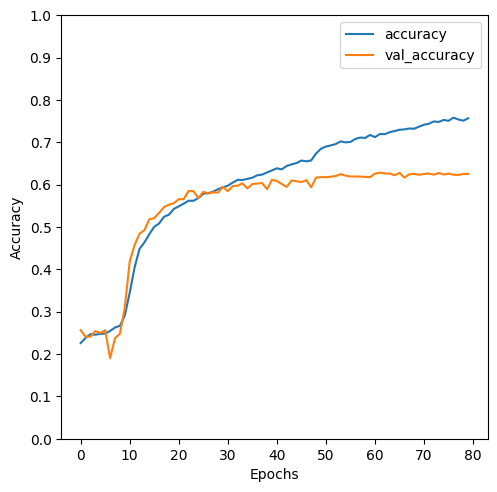

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5834 - loss: 1.2602
Test Accuracy = 61.466 %
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


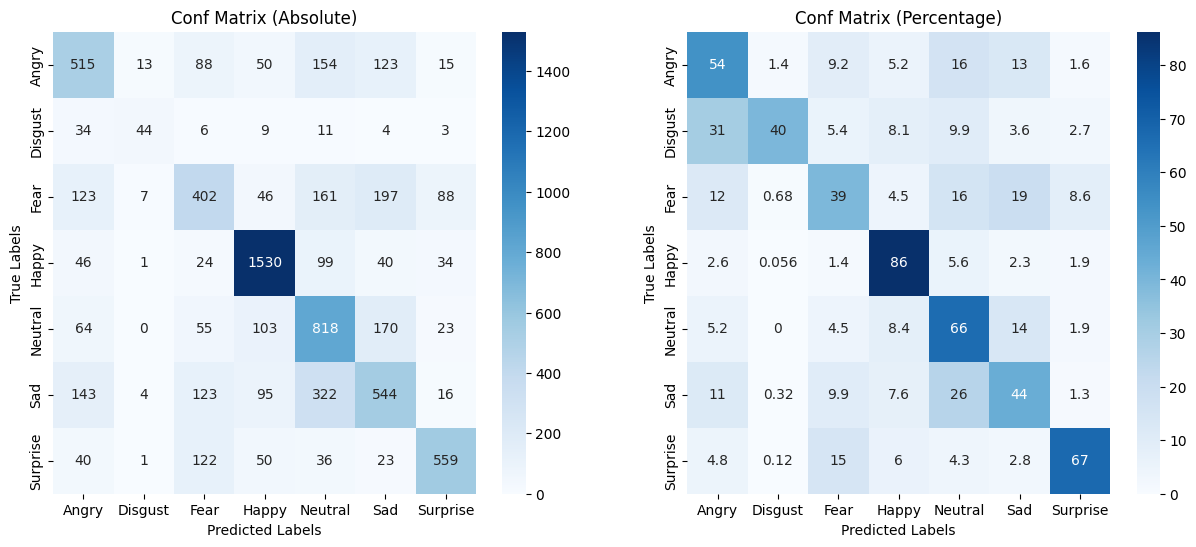

In [24]:
show_graphs(epochs, hist)
test_model(model_resnet)
conf_matrix(model_resnet)

In [25]:
generate_report(model_resnet)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       958
           1       0.63      0.40      0.49       111
           2       0.49      0.39      0.44      1024
           3       0.81      0.86      0.84      1774
           4       0.51      0.66      0.58      1233
           5       0.49      0.44      0.46      1247
           6       0.76      0.67      0.71       831

    accuracy                           0.61      7178
   macro avg       0.60      0.57      0.58      7178
weighted avg       0.61      0.61      0.61      7178



In [26]:
def create_densenet_model(learning_rate):
    base_model = keras.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=(48,48,3)
    )
    
    inputs = keras.layers.Input(shape=(48,48,1))
    x = keras.layers.Conv2D(3, 3, padding='same', activation='relu')(inputs)
    x = base_model(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(7, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [27]:
model = create_densenet_model(0.001)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1, 1, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,695,461 (29.36 MB)

 Trainable params: 7,611,813 (29.04 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [3]:
model_densenet, epochs, hist = train_model(create_densenet_model, datagen, learning_rate=0.0001, epochs=120, 
                                     batch_size=32, callbacks=[early_stopping, reduce_lr])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725308923.740837      75 service.cc:145] XLA service 0x7dad0c0082f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725308923.740906      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/628 ━━━━━━━━━━━━━━━━━━━━ 20:25:40 117s/step - accuracy: 0.1562 - loss: 2.5990

I0000 00:00:1725308984.606842      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


604/628 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2216 - loss: 2.0091

I0000 00:00:1725309069.139925      74 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_425', 12 bytes spill stores, 12 bytes spill loads



628/628 ━━━━━━━━━━━━━━━━━━━━ 221s 165ms/step - accuracy: 0.2226 - loss: 2.0041 - val_accuracy: 0.3489 - val_loss: 1.7301 - learning_rate: 1.0000e-04
Epoch 2/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.3341 - loss: 1.6903 - val_accuracy: 0.4528 - val_loss: 1.4333 - learning_rate: 1.0000e-04
Epoch 3/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.4095 - loss: 1.5199 - val_accuracy: 0.4974 - val_loss: 1.3290 - learning_rate: 1.0000e-04
Epoch 4/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.4622 - loss: 1.4145 - val_accuracy: 0.5189 - val_loss: 1.2499 - learning_rate: 1.0000e-04
Epoch 5/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.4827 - loss: 1.3544 - val_accuracy: 0.5205 - val_loss: 1.2666 - learning_rate: 1.0000e-04
Epoch 6/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.5035 - loss: 1.3136 - val_accuracy: 0.5362 - val_loss: 1.2787 - learning_rate: 1.0000e-04
Epoch 7/120
628/628 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step -

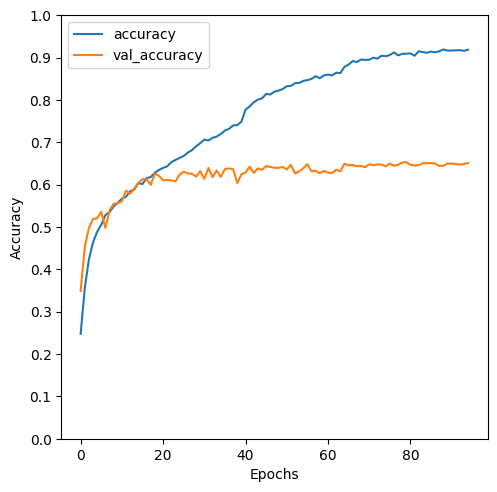

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6346 - loss: 1.7768
Test Accuracy = 65.213 %
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step


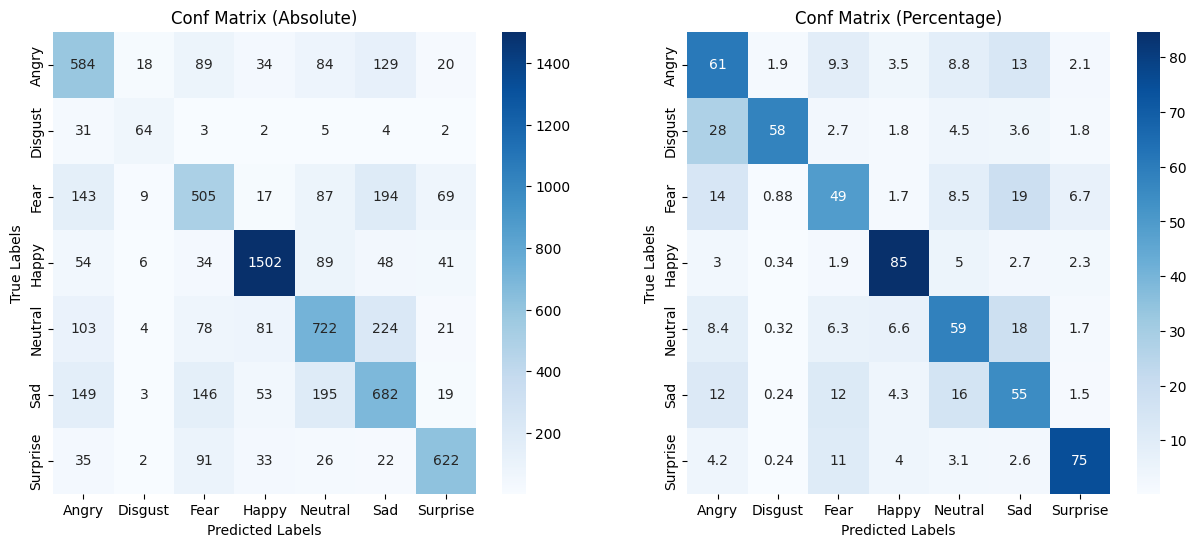

In [4]:
show_graphs(epochs, hist)
test_model(model_densenet)
conf_matrix(model_densenet)

In [5]:
generate_report(model_densenet)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           0       0.53      0.61      0.57       958
           1       0.60      0.58      0.59       111
           2       0.53      0.49      0.51      1024
           3       0.87      0.85      0.86      1774
           4       0.60      0.59      0.59      1233
           5       0.52      0.55      0.53      1247
           6       0.78      0.75      0.77       831

    accuracy                           0.65      7178
   macro avg       0.64      0.63      0.63      7178
weighted avg       0.66      0.65      0.65      7178



In [6]:
model_cnn.save('model-cnn.h5')
model_vgg.save('model-vgg.h5')
model_resnet.save('model-resnet.h5')
model_densenet.save('model-densenet.h5')